# Model Predict

In [1]:
import time
import six
import sys

import cifar_input
import numpy as np
import resnet_model
import tensorflow as tf

import os
import wget
import pandas as pd
from pathlib import Path


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
def get_file_name(img_url, f_name):
    try:
        file_name = wget.download(img_url, out= f_name)
    except Exception as e:
        print(e)
    return f_name

In [3]:
def get_image_tensor(f_name):
    image_size = 128
    batch_size = 1
    num_classes = 33
    
    filename_queue = tf.train.string_input_producer(tf.gfile.Glob(f_name))
    
    image_reader = tf.WholeFileReader()

    file_path, image_file = image_reader.read(filename_queue)
    
    
    image = tf.image.decode_jpeg(image_file, channels=3)
        
    longer = tf.reduce_max(tf.shape(image))
    image = tf.image.resize_image_with_crop_or_pad(image, longer, longer)
    image = tf.image.resize_images(image, [128, 128], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.resize_image_with_crop_or_pad(
            image, image_size, image_size)
    
    temp_image = image
    
    image = tf.image.per_image_standardization(image)
    label = tf.Variable([1])
    
    indices = tf.reshape(tf.range(0, batch_size, 1), [batch_size, 1])
    
    image = tf.expand_dims(image, 0)
    
    # random label just for test
    label = tf.expand_dims(label, 0)
    
    label = tf.sparse_to_dense(
        tf.concat(values=[indices, label], axis=1),
        [batch_size, num_classes], 1.0, 0.0)
    
    return image, label, temp_image

In [4]:
import joblib

cate_dict = joblib.load('./fasion_data/filtered_cate_mapping_dict_08_04')

In [5]:
cate_idx_dict = {}

for key, value in cate_dict.items():
    cate_idx_dict[value] = key

In [6]:
file_name_list = joblib.load('./fasion_data/train_file_name_list_08_04')
class_label_list = joblib.load('./fasion_data/train_class_label_list_08_04')

Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /root/jude/project/fdm/amazon_log_08_04/model.ckpt-78094


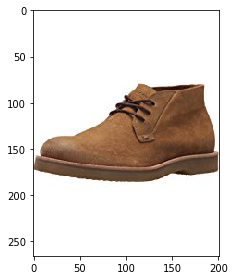




=========== Image Feature Vector ========


=========== Cateogry ========


Clothing, Shoes & Jewelry||Men||Clothing||Active


ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueueManyV2[Tcomponents=[DT_STRING], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](input_producer, input_producer/RandomShuffle)]]


Exception in thread QueueRunnerThread-input_producer-input_producer/input_producer_EnqueueMany:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/queue_runner_impl.py", line 238, in _run
    enqueue_callable()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 1229, in _single_operation_run
    target_list_as_strings, status, None)
  File "/usr/lib/python2.7/contextlib.py", line 24, in __exit__
    self.gen.next()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/errors_impl.py", line 467, in raise_exception_on_not_ok_status
    c_api.TF_GetCode(status.status))
CancelledError: Enqueue operation was cancelled
	 [[Node: input_producer/input_producer_EnqueueMany = QueueEnqueu

In [7]:
import os
from PIL import Image
import time



with tf.Session() as sess:
    
    batch_size = 1
    num_classes = 33

    hps = resnet_model.HParams(batch_size=batch_size,
                                   num_classes=num_classes,
                                   min_lrn_rate=0.0001,
                                   lrn_rate=0.1,
                                   num_residual_units=5,
                                   use_bottleneck=False,
                                   weight_decay_rate=0.0002,
                                   relu_leakiness=0.1,
                                   optimizer='mom')
    images = tf.placeholder(tf.float32, shape=(1, 128, 128, 3))
    labels = tf.placeholder(tf.int32, shape=(1, 33))
    model = resnet_model.ResNet(hps, images, labels, 'test')
    model.build_graph()
    
    saver = tf.train.Saver()
    log_root = 'amazon_log_08_04/'

    try:
        ckpt_state = tf.train.get_checkpoint_state(log_root)
    except tf.errors.OutOfRangeError as e:
        tf.logging.error('Cannot restore checkpoint: %s', e)

    timestr = time.strftime("%Y%m%d_%H%M%S")
    img_url = 'https://images-na.ssl-images-amazon.com/images/I/41s8d4b0CIL._AC_SR201,266_.jpg'
    img_url = 'https://images-na.ssl-images-amazon.com/images/I/91MR26Sa4zL._AC_SR201,266_.jpg'
    image, label, temp_image = get_image_tensor(get_file_name(img_url, timestr))
    init = tf.global_variables_initializer()
    sess.run(init)
    
    saver.restore(sess, os.getcwd() + '/' + ckpt_state.model_checkpoint_path)
    
    tf.train.start_queue_runners()
    
    img_eval = image.eval()
    label_eval = label.eval()
    
    
    Image.fromarray(temp_image.eval(), 'RGB').save('bbb.jpeg')
    feed_dict = {images: img_eval, labels: label_eval}
    
    predictions, predict_labels, m_images, global_avg_pool = sess.run([model.predictions, model.labels, model._images, model.global_avg_pool ], feed_dict)
    predictions = np.argmax(predictions, axis=1)
    
    from skimage import io

    io.imshow(io.imread(img_url))
    io.show()

    print('\n\n')
    print('=========== Image Feature Vector ========')
    print('\n')

#     print(len(model.global_avg_pool[0]))
    print('=========== Cateogry ========')
    print('\n')
    print(cate_idx_dict[predictions[0]])
    print('\n')

## Tensorboard Visualization

In [10]:
import os
from PIL import Image
import time
import joblib


with tf.Session() as sess:
    
    batch_size = 1
    num_classes = 33

    hps = resnet_model.HParams(batch_size=batch_size,
                                   num_classes=num_classes,
                                   min_lrn_rate=0.0001,
                                   lrn_rate=0.1,
                                   num_residual_units=5,
                                   use_bottleneck=False,
                                   weight_decay_rate=0.0002,
                                   relu_leakiness=0.1,
                                   optimizer='mom')
    
    images = tf.placeholder(tf.float32, shape=(1, 128, 128, 3))
    labels = tf.placeholder(tf.int32, shape=(1, 33))
    model = resnet_model.ResNet(hps, images, labels, 'test')
    model.build_graph()
    
    saver = tf.train.Saver()
    log_root = 'amazon_log_08_04/'

    try:
        ckpt_state = tf.train.get_checkpoint_state(log_root)
    except tf.errors.OutOfRangeError as e:
        tf.logging.error('Cannot restore checkpoint: %s', e)

    
    image_list = []
    label_list = []
    
    c = 1
    for file_name, class_label in zip(file_name_list[0:2000], class_label_list[0:2000]):
        print(c)
        c += 1
        image, tensor_label, temp_image = get_image_tensor(file_name)
        image_list.append(image)
        label_list.append(class_label)
    
        
    init = tf.global_variables_initializer()
    sess.run(init)
    saver.restore(sess, os.getcwd() + '/' + ckpt_state.model_checkpoint_path)
    
    tf.train.start_queue_runners()
    
    image_eval_list = []
    for i in range(len(image_list)):
        print(i)
        image_eval_list.append(image_list[i].eval())
    tensor_label_eval = tensor_label.eval()
    
    extract_feature_list = []
    
    for i in range(len(image_eval_list)):
        print(i)
        
        image_eval = image_eval_list[i]
        
        feed_dict = {images: image_eval, labels: tensor_label_eval}
        predictions, global_avg_pool = sess.run([model.predictions, model.global_avg_pool ], feed_dict)

        extract_feature_list.append(global_avg_pool[0])

ValueError: Variable init/init_conv/DW already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/root/jude/project/fdm/resnet_model.py", line 295, in _conv
    stddev=np.sqrt(2.0/n)))
  File "/root/jude/project/fdm/resnet_model.py", line 72, in _build_model
    x = self._conv('init_conv', x, 3, 3, 16, self._stride_arr(1))
  File "/root/jude/project/fdm/resnet_model.py", line 59, in build_graph
    self._build_model()


In [13]:
np.savetxt('image_features/2000_features',extract_feature_list)

In [12]:
len(extract_feature_list)

2000

In [2]:
import joblib
import numpy as np

extract_feature_list = joblib.load('board_dir/extract_feature_list')
features = []
for each in extract_feature_list:
    features.append(each)
features = np.asarray(features, np.float32)

In [8]:
features_tf = tf.Variable(features, name='amazon_image_feature')

In [5]:
features

array([[ 0.1970201 , -0.25424314, -0.10068889, ..., -0.41626313,
         0.9368937 , -0.4651373 ],
       [ 0.37116838,  1.0558157 ,  0.13029003, ...,  0.23557165,
         1.59525025, -0.09143862],
       [ 0.17047159,  0.91391456, -0.36355782, ...,  0.09387276,
         0.78751522, -0.05850422],
       ..., 
       [ 0.30070642,  0.24187823,  0.57950783, ...,  1.99815547,
        -0.40107095, -0.32822695],
       [ 1.41975904,  0.01061956, -0.1316949 , ..., -0.2009003 ,
        -0.06679143, -0.68702388],
       [ 0.52750415,  1.6887641 ,  0.98772365, ...,  0.40193173,
        -0.25117528, -0.29417571]], dtype=float32)

### Visualize from Extracted Features

In [10]:
import cv2

img_data=[]
for file_name in file_name_list[0:1000]:
#     print ('Loaded the images of dataset-'+'{}\n'.format(file_name))
    input_img=cv2.imread(file_name)
    input_img_resize=cv2.resize(input_img,(128,128)) # you can choose what size to resize your data
    img_data.append(input_img_resize)
img_data = np.array(img_data)

In [11]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding

    Args:
      data: NxHxW[x3] tensor containing the images.

    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data

In [21]:
import scipy.misc
LOG_DIR = 'board_dir'

sprite = images_to_sprite(img_data)
scipy.misc.imsave(os.path.join(LOG_DIR, 'sprite.png'), sprite)

In [16]:
label_list = []
for each in class_label_list[0:1000]:
    label_list.append(each)

In [20]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector

LOG_DIR = 'board_dir'
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

with open(metadata, 'w') as metadata_file:
    for row in label_list:
        metadata_file.write('%d\n' % row)

with tf.Session() as sess:
    saver = tf.train.Saver([features_tf])
    sess.run(features_tf.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images.ckpt'))
    
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    embedding.tensor_name = features_tf.name
    embedding.metadata_path = 'metadata.tsv'
    
    embedding.sprite.image_path = 'sprite.png'
    embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])
    
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [21]:
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.tensorboard.plugins import projector


A_DIR = 'logs'
metadata = os.path.join(A_DIR, 'metadata.tsv')

mnist = input_data.read_data_sets('MNIST_data')
images = tf.Variable(mnist.test.images, name='images')

with open(metadata, 'w') as metadata_file:
    for row in mnist.test.labels:
        metadata_file.write('%d\n' % row)

with tf.Session() as sess:
    saver = tf.train.Saver([images])

    sess.run(images.initializer)
    saver.save(sess, os.path.join(A_DIR, 'images.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    print(images)
    print(mnist.test.labels)
    embedding.tensor_name = images.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = 'metadata.tsv'
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(A_DIR), config)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
<tf.Variable 'images:0' shape=(10000, 784) dtype=float32_ref>
[7 2 1 ..., 4 5 6]
